In [1]:
import sys
sys.path.append("..")

In [16]:
from libhiaac.utils.dataset import DataLoader
from libhiaac.utils.experiment import Experiment, ExperimentRunner
from libhiaac.temporal.datasets.kuhar import BalancedTimeDomainKuHar
from libhiaac.temporal.transforms.transforms import Composer, FFT1D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from libhiaac.utils import experiment
from libhiaac.utils.manifold import ManifoldFitTransform

In [3]:
train_dataset = BalancedTimeDomainKuHar(
    dataset_path="../data/datasets/KuHar/Balanced", download=True, mode="train")
val_dataset = BalancedTimeDomainKuHar(
    dataset_path="../data/datasets/KuHar/Balanced", download=True, mode="validation")
test_dataset = BalancedTimeDomainKuHar(
    dataset_path="../data/datasets/KuHar/Balanced", download=True, mode="test")

'../data/datasets/KuHar/Balanced/train.csv' already exists and will not be downloaded again
Done!
'../data/datasets/KuHar/Balanced/val.csv' already exists and will not be downloaded again
Done!
'../data/datasets/KuHar/Balanced/test.csv' already exists and will not be downloaded again
Done!


In [12]:
class OldSchoolKuHar:
    def __init__(self, datasets):
        self.datasets = datasets
        self.it = 0

    def to_old_school_kuhar(self, dataset):
        back_to_kuhar = []
        back_to_kuhar_labels = []

        for sample in dataset:
            kuhar_sample = np.concatenate([sample["accelerometer"].flatten(), sample["gyroscope"].flatten()])
            back_to_kuhar.append(kuhar_sample)
            back_to_kuhar_labels.append(sample["meta"]["class"])

        back_to_kuhar = np.stack(back_to_kuhar, axis=0)
        back_to_kuhar_labels = np.array(back_to_kuhar_labels)
        return back_to_kuhar, back_to_kuhar_labels

    def __iter__(self):
        self.it = 0
        return self

    def __next__(self):
        if self.it != 0:
            raise StopIteration
        self.it += 1
        Xs, Ys = [], []
        for dataset in self.datasets:
            X, Y = self.to_old_school_kuhar(dataset=dataset)
            Xs.append(X)
            Ys.append(Y)
        return np.concatenate(Xs, axis=0), np.concatenate(Ys, axis=0)


In [13]:
old_kuhar = OldSchoolKuHar([train_dataset, val_dataset, test_dataset])
Xs, Ys = next(old_kuhar)
print(Xs.shape, Ys.shape)

(3330, 1800) (3330,)


In [18]:
experiments = [
    Experiment(func=ManifoldFitTransform("t-sne", n_components=2), description="T-SNE"),
    Experiment(func=ManifoldFitTransform("isomap", n_components=2), description="IsoMap")
]
runner = ExperimentRunner(experiments=experiments)


In [19]:
results = runner.run(Xs)

--- Running experiment: T-SNE ---
--- Running experiment: IsoMap ---


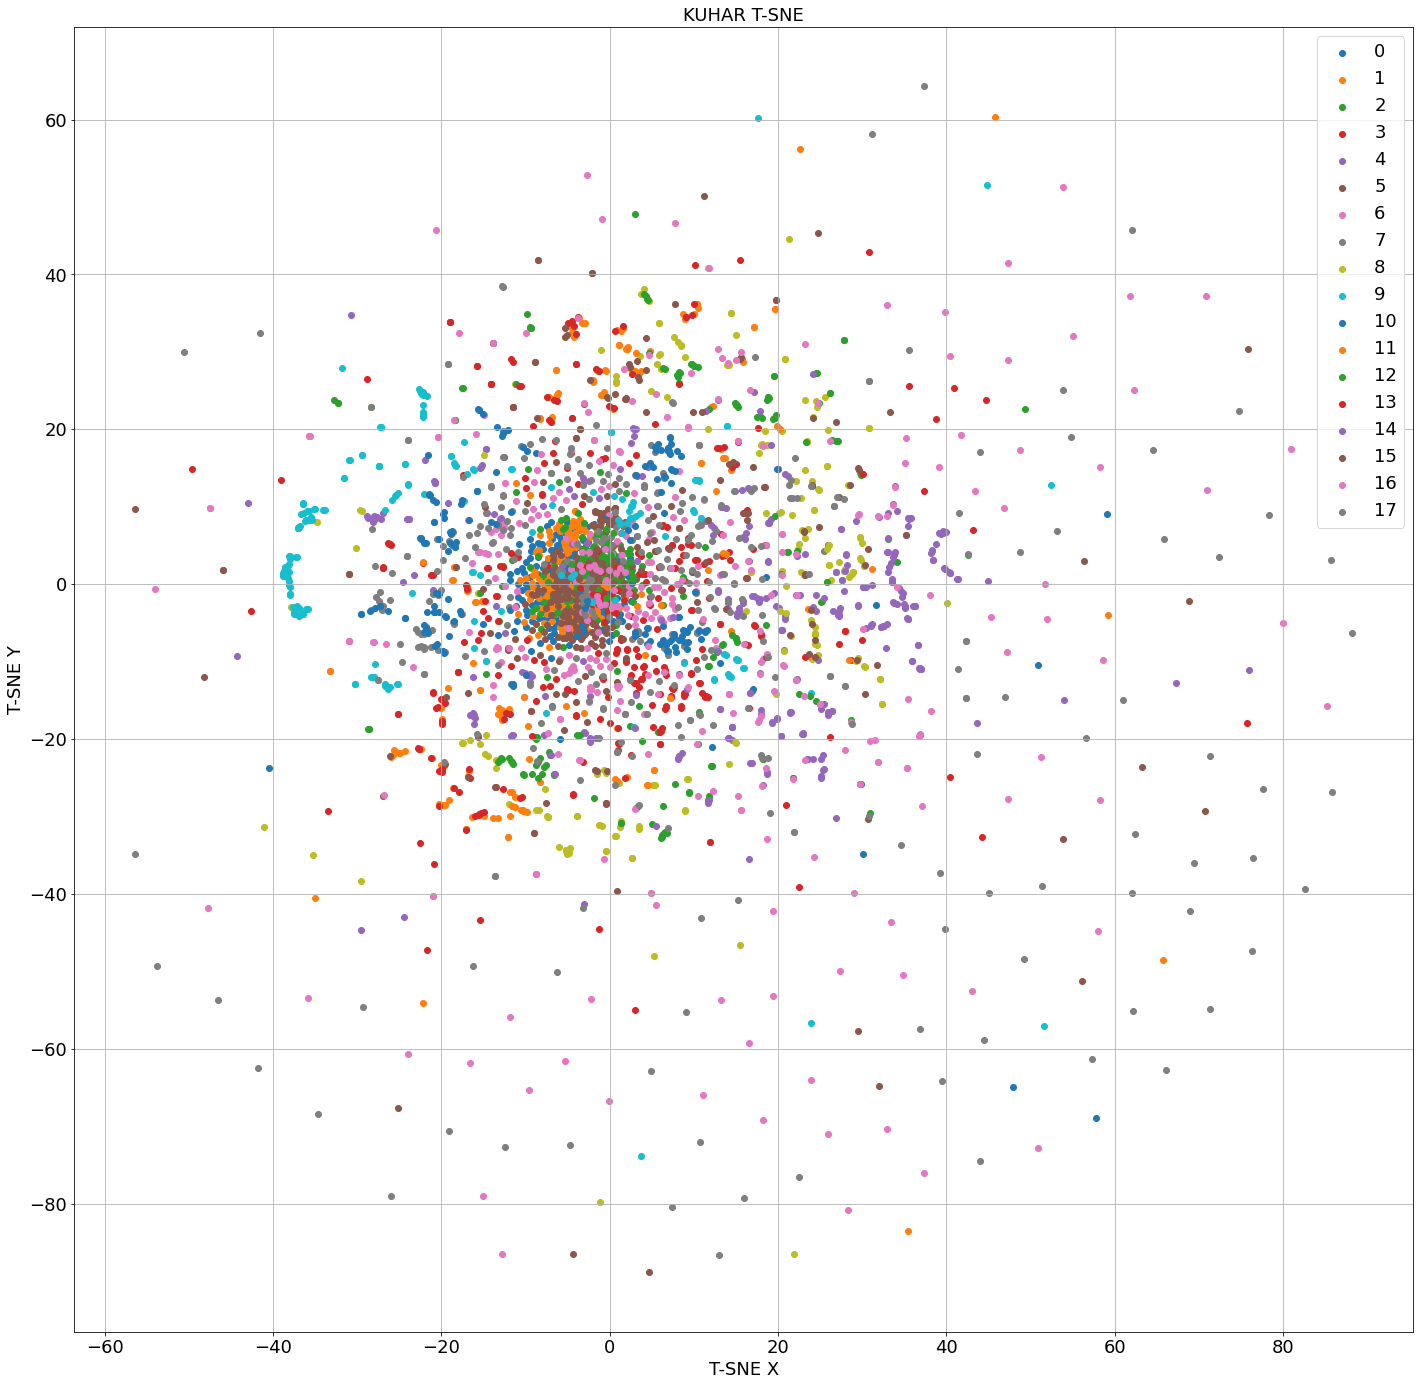

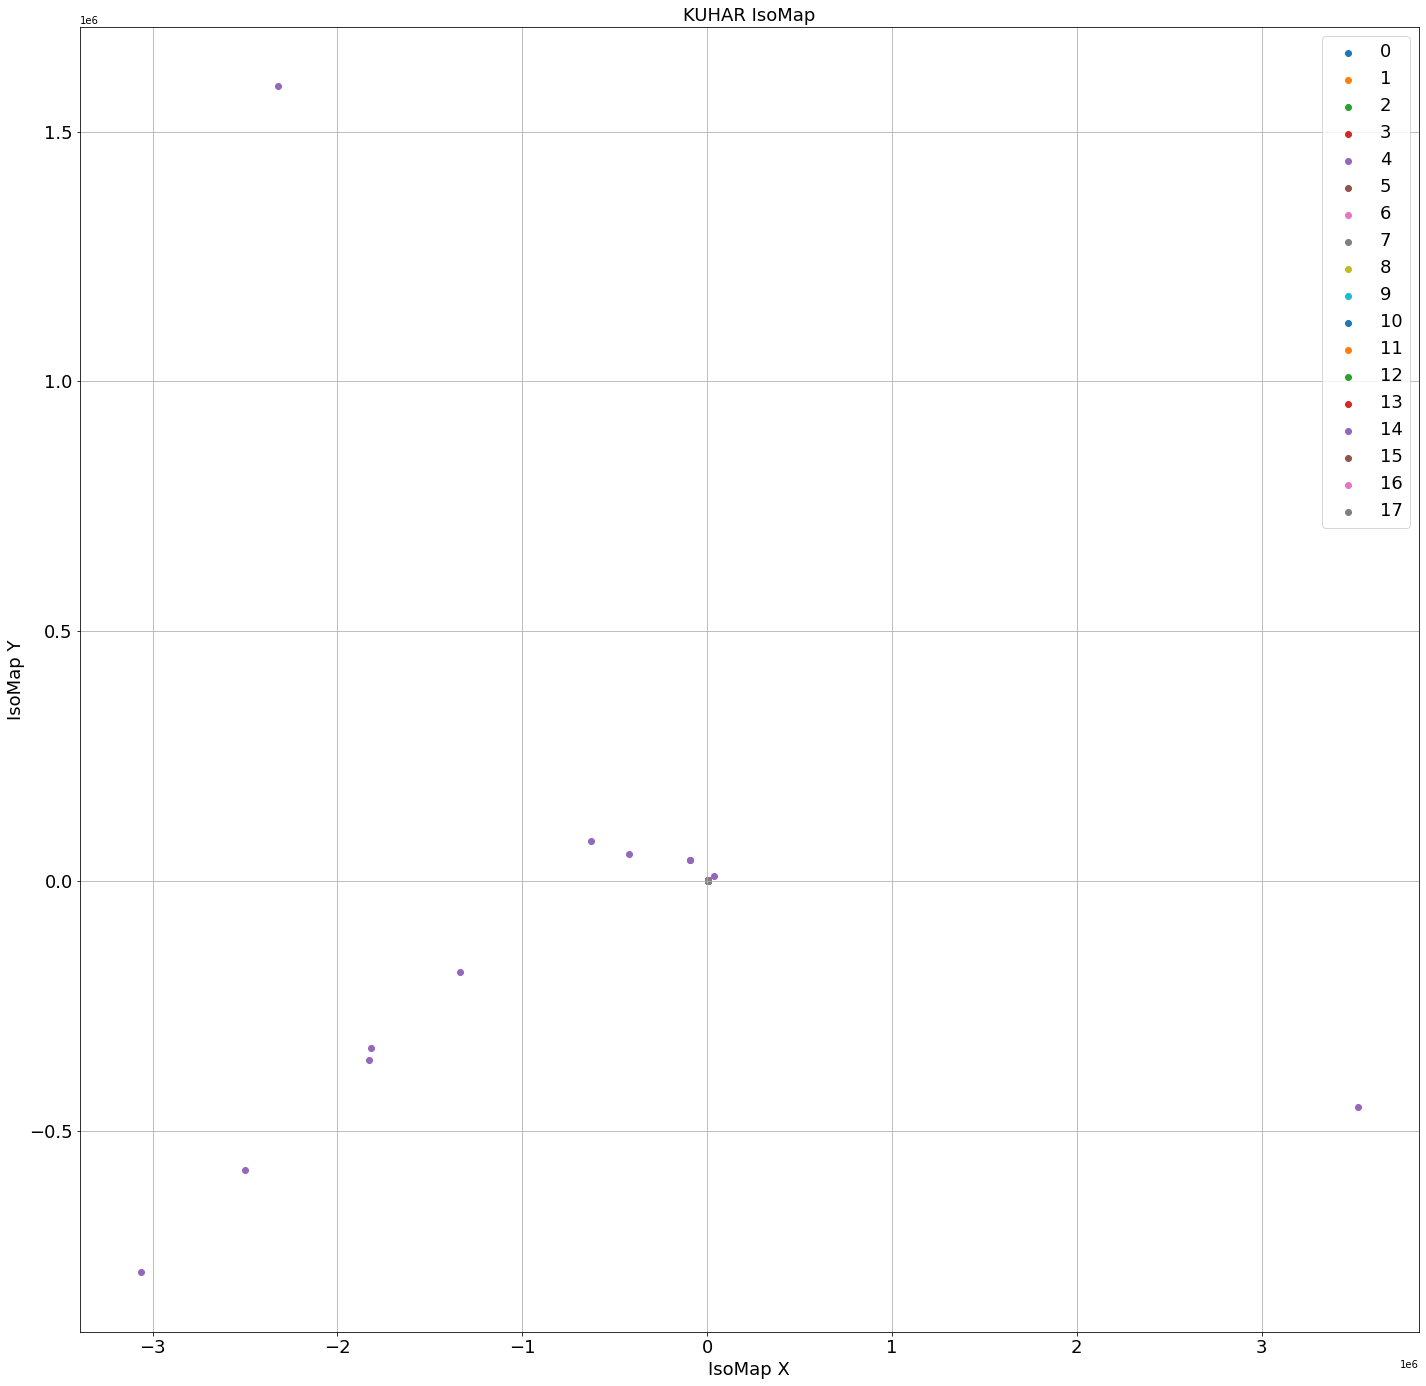

In [22]:
for res in results:
    df = pd.DataFrame(res.result, columns=["X", "Y"])
    df["label"] = Ys

    fig = plt.figure(figsize=(24,24))
    ax = fig.add_subplot(1,1,1)
    ax.set_title(f"KUHAR {res.description}", fontsize=18)
    ax.set_xlabel(f"{res.description} X", fontsize=18)
    ax.set_ylabel(f"{res.description} Y", fontsize=18)
        
    for label, points in df.groupby("label"):
        ax.scatter(points["X"], points["Y"], label=label)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    ax.legend(prop={'size': 18})
    ax.grid()
    plt.show()
    

In [23]:
transformations = Composer([
    FFT1D()
])

train_dataset = BalancedTimeDomainKuHar(
    dataset_path="../data/datasets/KuHar/Balanced", download=True, mode="train", transforms=transformations)
val_dataset = BalancedTimeDomainKuHar(
    dataset_path="../data/datasets/KuHar/Balanced", download=True, mode="validation", transforms=transformations)
test_dataset = BalancedTimeDomainKuHar(
    dataset_path="../data/datasets/KuHar/Balanced", download=True, mode="test", transforms=transformations)

'../data/datasets/KuHar/Balanced/train.csv' already exists and will not be downloaded again
Done!
'../data/datasets/KuHar/Balanced/val.csv' already exists and will not be downloaded again
Done!
'../data/datasets/KuHar/Balanced/test.csv' already exists and will not be downloaded again
Done!


In [24]:
old_kuhar = OldSchoolKuHar([train_dataset, val_dataset, test_dataset])
Xs, Ys = next(old_kuhar)
print(Xs.shape, Ys.shape)

(3330, 1800) (3330,)


In [26]:
results = runner.run(Xs)

--- Running experiment: T-SNE ---
--- Running experiment: IsoMap ---


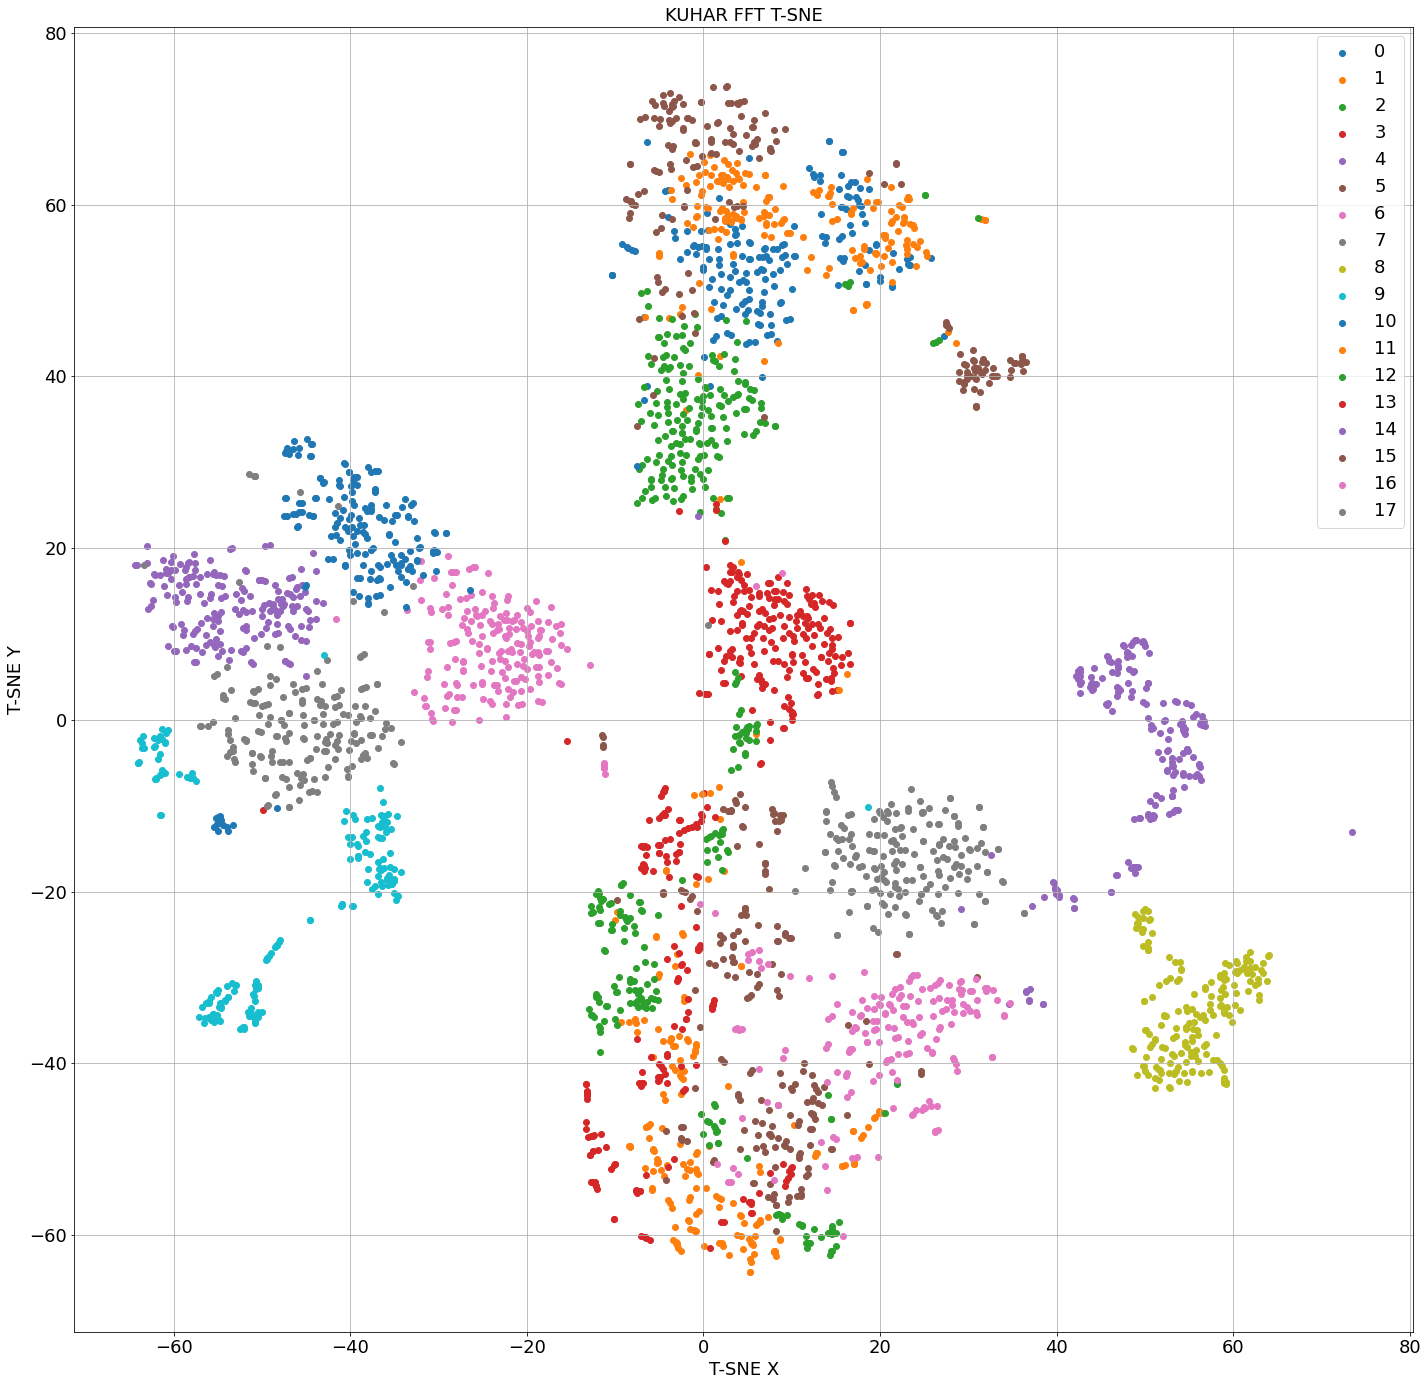

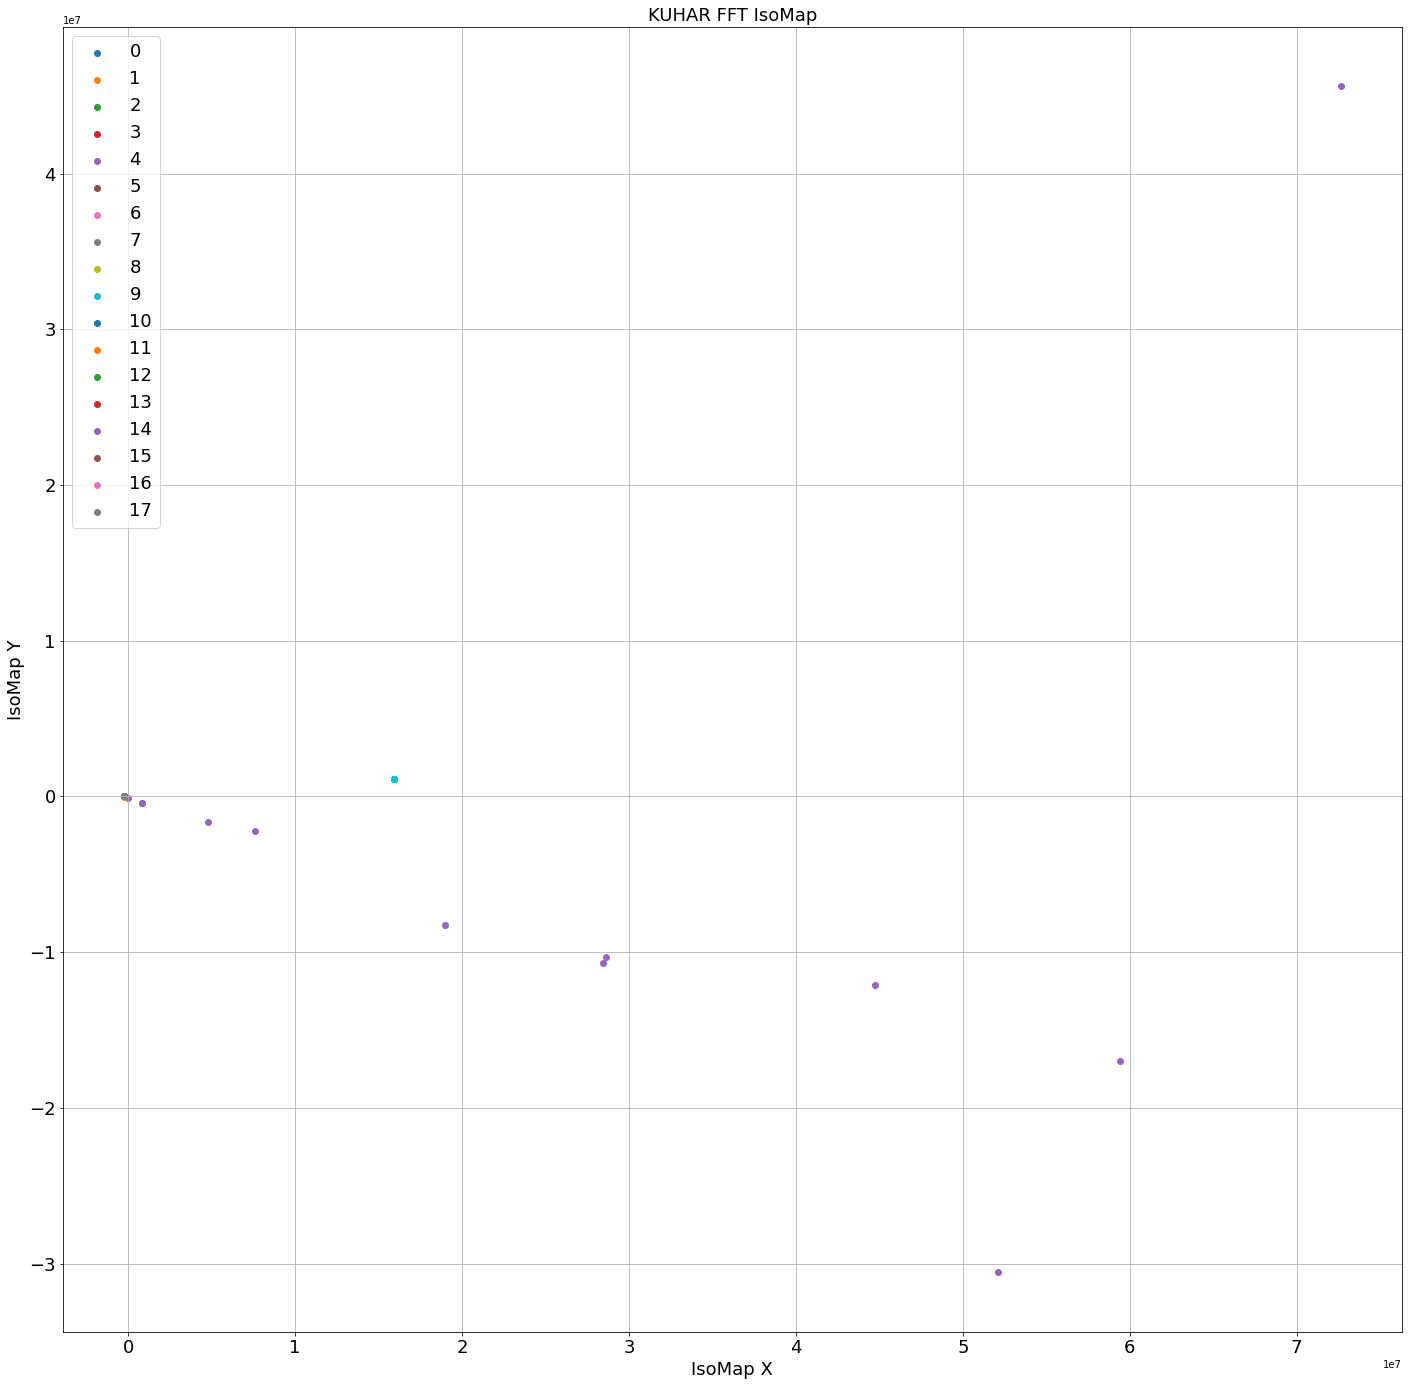

In [27]:
for res in results:
    df = pd.DataFrame(res.result, columns=["X", "Y"])
    df["label"] = Ys

    fig = plt.figure(figsize=(24,24))
    ax = fig.add_subplot(1,1,1)
    ax.set_title(f"KUHAR FFT {res.description}", fontsize=18)
    ax.set_xlabel(f"{res.description} X", fontsize=18)
    ax.set_ylabel(f"{res.description} Y", fontsize=18)
        
    for label, points in df.groupby("label"):
        ax.scatter(points["X"], points["Y"], label=label)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    ax.legend(prop={'size': 18})
    ax.grid()
    plt.show()
    